# Cascade Classification

HAAR CASCEDE è un algoritmo di machine learning di object detection proposto da Paul Viola e Michael Jones nel loro [paper](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) e migliorato successivamente da [Rainer Lienhart](http://wiki.opencv.org.cn/images/5/52/MRL-TR-May02-revised-Dec02.pdf).

Con questo processo di machine learning, la cascade function è stata allenata con un gran campione di immagini (positive and negative). Questo modello ottenuto può essere riutilizzato per trovare oggetti in altri immagini. 


In [1]:
# Download the test image and utils files
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/fav/PW2020/image.jpg

--2022-11-07 19:57:22--  https://frenzy86.s3.eu-west-2.amazonaws.com/fav/PW2020/image.jpg
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 3.5.245.179
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|3.5.245.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1315241 (1.3M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.25M   664KB/s    in 1.9s    

2022-11-07 19:57:25 (664 KB/s) - ‘image.jpg’ saved [1315241/1315241]



In [2]:
#Importiamo opencv
import cv2 
import numpy as np

%matplotlib inline 
from matplotlib import pyplot as plt 
import pylab
pylab.rcParams['figure.figsize'] = (12, 8)

## Salvare immagine da cam, tramite Colab

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Caricare immagine da disco

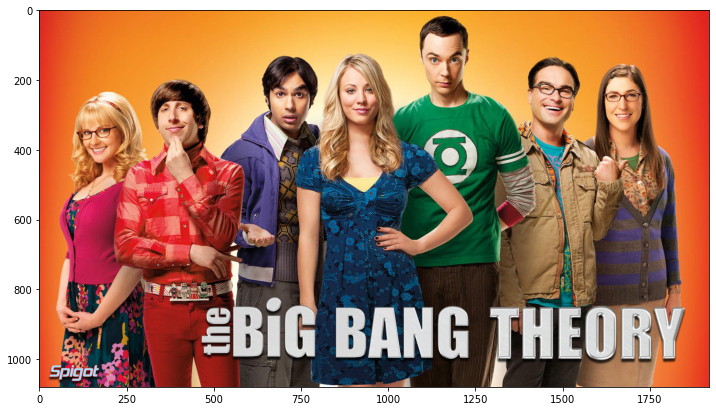

In [3]:
## DISPLAY THE IMAGE WITH MATPLOTLIB

base_image = cv2.imread('image.jpg')
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB));

In [ ]:
#from google.colab.patches import cv2_imshow
#cv2_imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))

# Face Detection

Useremo un modello pre-trainato haarcascade_frontalface_default.xml per localizzare tutti i volti all'interno dll'immagine. Se volete approfondire i parametri e settaggi della funzione detectMultiScale [here](https://docs.opencv.org/3.4/d1/de5/classcv_1_1CascadeClassifier.html#aaf8181cb63968136476ec4204ffca498).

**Note**: In tutti gli esempi, bisogna ricaricare l'immagini a colori, perchè ogni volta imshow riscrive l'immagine orginale con quella con le bounding boxes, però dobbiamo sempre ricordare che haarcascade funzion in scala di grigi, quindi l'immagine a colori deve necessariamente essere convertita ogni volta!)

In [4]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

In [6]:
#1 convert to greyscale
grey = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)

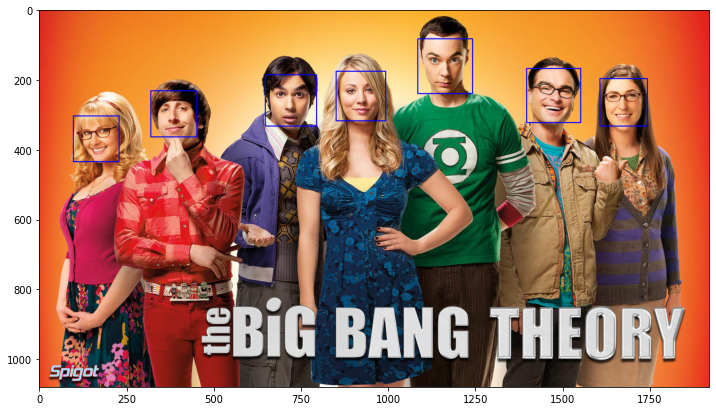

In [7]:
# this is a pre-trained face cascade
test_image = cv2.imread('image.jpg')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(grey, 1.3, 5)
for (x,y,w,h) in faces:
     cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB));

## Smile Detection

Per la detection del sorriso nell'immagine, utilizzeremo sempre un modello pre-trainato, haarcascade_smile.xml

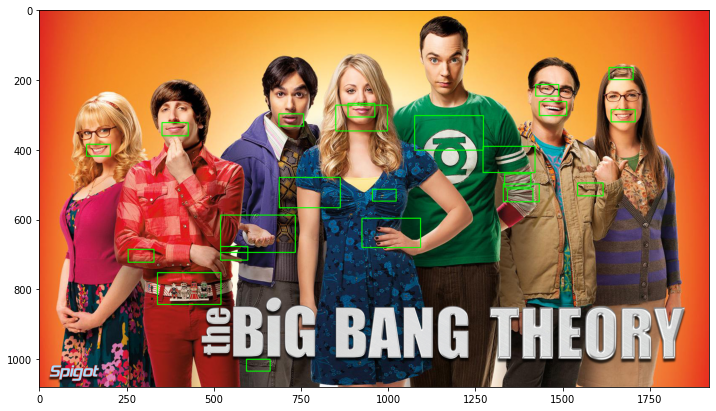

In [8]:
# this is a pre-trained face cascade
test_image = cv2.imread('image.jpg')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
smiles = smile_cascade.detectMultiScale(grey, 1.3, 20)
for (x,y,w,h) in smiles:
     cv2.rectangle(test_image,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB));

Come si può evincere dal risultato, alcune detection risultano essere corrette,ma ci sono ancora un gran numero di falsi positivi.

Come possiamo ovviare questo problema? Possiamo inserire dei vincoli, ovvero, imporre di cercare il sorriso all'interno della bounding box del volto

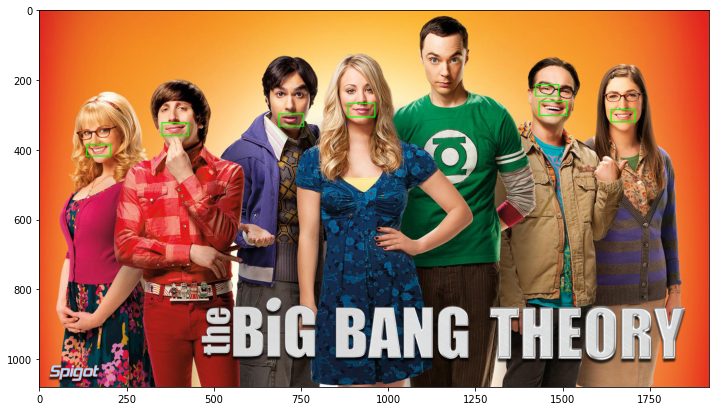

In [9]:
# this is a pre-trained face cascade
test_image = cv2.imread('image.jpg')
for (x,y,w,h) in faces:
    for (x_s,y_s,w_s,h_s) in smiles:
        if( (x <= x_s) and (y <= y_s) and ( x+w >= x_s+w_s) and ( y+h >= y_s+h_s)):
            cv2.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(0,255,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB));

# Eye Detection

NAche in questo caso per l'eye detection utilizzeremo il modello pre-trainato haarcascade_frontalface_default.xml

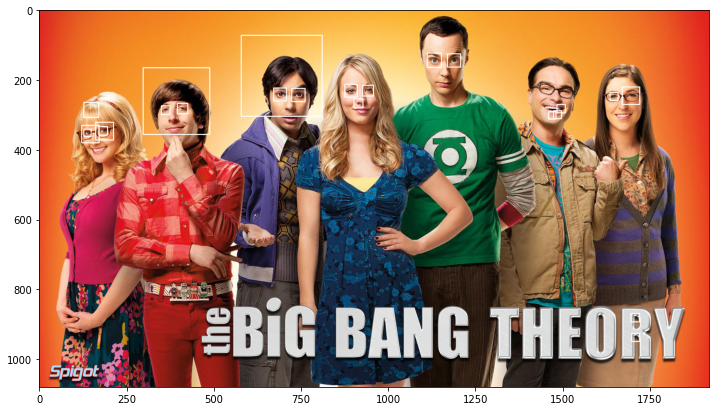

In [10]:
test_image = cv2.imread('image.jpg')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
eyes = eye_cascade.detectMultiScale(grey, 1.1, 1)
for (x,y,w,h) in eyes:
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,255,255),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

Come detto prima, anche in questo caso ci troveremo davanti a molti falsi postivi, quindi dobbiamo cercare gli occhi all'interno della faccia

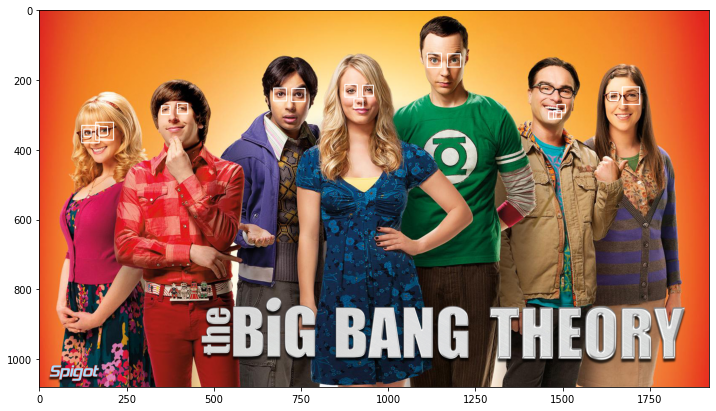

In [11]:
test_image = cv2.imread('image.jpg')
for (x,y,w,h) in faces:
#cv2.rectangle(smile_faces_base_image,(x,y),(x+w,y+h),(255,0,0),2)
    for (x_s,y_s,w_s,h_s) in eyes:
        if( (x <= x_s) and (y <= y_s) and ( x+w >= x_s+w_s) and ( y+h >= y_s+h_s)):
            cv2.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(255,255,255),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB));

## Putting all together



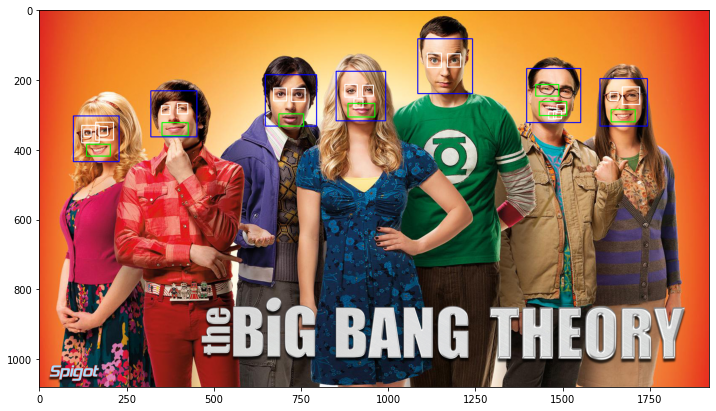

In [12]:
test_image = cv2.imread('image.jpg')
for (x,y,w,h) in faces:
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
    for (x_s,y_s,w_s,h_s) in eyes:
        if( (x <= x_s) and (y <= y_s) and ( x+w >= x_s+w_s) and ( y+h >= y_s+h_s)):
            cv2.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(255,255,255),2)
    for (x_s,y_s,w_s,h_s) in smiles:
        if( (x <= x_s) and (y <= y_s) and ( x+w >= x_s+w_s) and ( y+h >= y_s+h_s)):
            cv2.rectangle(test_image, (x_s,y_s),(x_s+w_s,y_s+h_s),(0,255,0),2)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

In [ ]:
# finish!

In [ ]:
## Volendo possiamo anche utilizzare il classificatore degli occhiali:

In [13]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/fav/PW2020/haarcascade_eye_tree_eyeglasses.xml

--2022-11-07 20:04:33--  https://frenzy86.s3.eu-west-2.amazonaws.com/fav/PW2020/haarcascade_eye_tree_eyeglasses.xml
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.144.46
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.144.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 601661 (588K) [text/xml]
Saving to: ‘haarcascade_eye_tree_eyeglasses.xml’

haarcascade_eye_tre 100%[===================>] 587.56K  1.30MB/s    in 0.4s    

2022-11-07 20:04:34 (1.30 MB/s) - ‘haarcascade_eye_tree_eyeglasses.xml’ saved [601661/601661]



In [14]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

glasses_cascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')

img = cv2.imread('image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

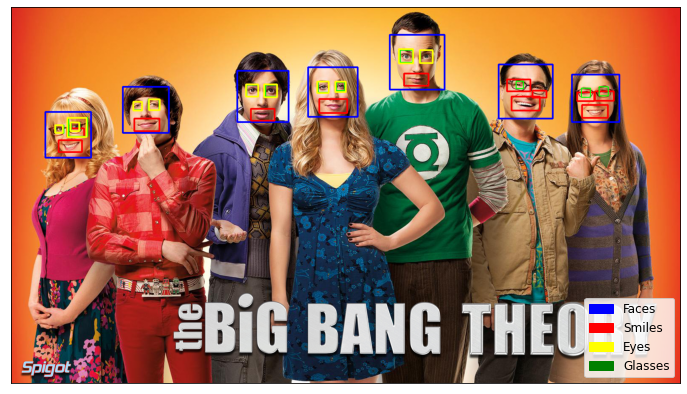

In [15]:
# default MultiScale paramters: scaleFactor=1.1, minNeighbors=3
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for(x, y, w, h) in faces:
    img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 3)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

    smiles = smile_cascade.detectMultiScale(roi_gray, minNeighbors=20)
    for(sx, sy, sw, sh) in smiles:
        cv2.rectangle(roi_color, (sx,sy), (sx+sw,sy+sh), (0,0,255), 3)
    
    glasses = glasses_cascade.detectMultiScale(roi_gray, scaleFactor=1.04, minNeighbors=1)
    for(gx, gy, gw, gh) in glasses:
        cv2.rectangle(roi_color, (gx,gy), (gx+gw,gy+gh), (0,255,0), 2)
        
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for(ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (0,255,255), 3)
    
plt.xticks([])
plt.yticks([])

import matplotlib.patches as mpatches
face_patch = mpatches.Patch(color='blue', label='Faces')
smile_patch = mpatches.Patch(color='red', label='Smiles')
eye_patch = mpatches.Patch(color='yellow', label='Eyes')
glass_patch = mpatches.Patch(color='green', label='Glasses')
plt.legend(handles=[face_patch, smile_patch, eye_patch, glass_patch], 
           loc='lower right', fontsize=12)

imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Record a Video from webcam in Colab

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename='video.mp4'):
  js = Javascript("""
    async function recordVideo() {
      // mashes together the advanced_outputs.ipynb function provided by Colab, 
      // a bunch of stuff from Stack overflow, and some sample code from:
      // https://developer.mozilla.org/en-US/docs/Web/API/MediaStream_Recording_API

      // Optional frames per second argument.
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      // create a media recorder instance, which is an object
      // that will let you record what you stream.
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      // Video is a media element.  This line here sets the object which serves
      // as the source of the media associated with the HTMLMediaElement
      // Here, we'll set it equal to the stream.
      video.srcObject = stream;
      // We're inside an async function, so this await will fire off the playing
      // of a video. It returns a Promise which is resolved when playback has 
      // been successfully started. Since this is async, the function will be 
      // paused until this has started playing. 
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // and now, just wait for the capture button to get clicked in order to
      // start recording
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      // use a promise to tell it to stop recording
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);
    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))
  return filename

In [ ]:
# Run the function, get the video path as saved in your notebook, and play it back here.
from IPython.display import HTML
from base64 import b64encode

video_width = 300

video_path = record_video()
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")



<IPython.core.display.Javascript object>

Finished recording video. Saved binary under filename in current working directory: video.mp4


In [16]:
from google.colab.patches import cv2_imshow
#cv2_imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

vc = cv2.VideoCapture('video.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.avi', fourcc, 12, (640,480))

##Haarcascade function od detection FACE+SMILE+EYE
def detection(grayscale, img):
    face = face_cascade.detectMultiScale(grayscale, 1.3, 5)
    for (x_face, y_face, w_face, h_face) in face:
        cv2.rectangle(img, (x_face, y_face), (x_face+w_face, y_face+h_face), (255, 130, 0), 2)
        roi_grayscale = grayscale[y_face:y_face+h_face, x_face:x_face+w_face]
        roi_color = img[y_face:y_face+h_face, x_face:x_face+w_face] 
        eye = eye_cascade.detectMultiScale(roi_grayscale, 1.2, 18) 
        for (x_eye, y_eye, w_eye, h_eye) in eye:
            cv2.rectangle(roi_color,(x_eye, y_eye),(x_eye+w_eye, y_eye+h_eye), (0, 180, 60), 2) 
        smile = smile_cascade.detectMultiScale(roi_grayscale, 1.7, 20)
        for (x_smile, y_smile, w_smile, h_smile) in smile: 
            cv2.rectangle(roi_color,(x_smile, y_smile),(x_smile+w_smile, y_smile+h_smile), (255, 0, 130), 2)
    return img 

while True:
    _, img = vc.read() 
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    final = detection(grayscale, img)
    out.write(final)    
    cv2_imshow(final)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break 

out.release()
vc.release() 
cv2.destroyAllWindows()

In [ ]:
!pip install moviepy imageio==2.4.1 -q
!pip install --upgrade imageio-ffmpeg -q

     |████████████████████████████████| 3.3 MB 5.2 MB/s 


In [ ]:
## Restart Runtime

from moviepy.editor import *
path="output.avi" 

clip=VideoFileClip(path)
clip.ipython_display(width=640)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2433024/45929032 bytes (5.3%)5513216/45929032 bytes (12.0%)8863744/45929032 bytes (19.3%)11919360/45929032 bytes (26.0%)15122432/45929032 bytes (32.9%)18530304/45929032 bytes (40.3%)21635072/45929032 bytes (47.1%)24829952/45929032 bytes (54.1%)28098560/45929032 bytes (61.2%)30892032/45929032 bytes (67.3%)33726464/45929032 bytes (73.4%)35643392/45929032 bytes (77.6%)

100%|██████████| 43/43 [00:00<00:00, 167.10it/s]
